# Analyze identical Individuals
There are two Bronze Age Sardinians

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-44.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [25]:
def get_idx_iid(f,sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:])
    idx = samples.str.contains(sample)
    idx = np.where(idx)[0]
    if unique:
        assert(len(idx)==1)
        return idx[0]
    else:
        return idx
    
def get_coverage(f, j):
    """Get Coverage of sample j in hdf5 f"""
    ads =  f["calldata/AD"][:,j,:]
    ads[ads<0]=0
    cov = np.mean(ads)*2
    return cov

def get_markers_good(f, j, output=True, cutoff=0.99):
    """Get markers"""
    m = np.max(f["calldata/GP"][:,j,:], axis=1)
    idx = (m>cutoff)
    if output:
        c1 = np.mean(m>cutoff)
        print(f"Filtering to {cutoff} GP variants: {c1:.3f}x")
    return idx

def get_fraction_identical(f, sample1="SUC006", sample2="R26.SG", 
                           gp_cutoff=0, cutoff=0.98, output=True):
    """Get Fraction of Identical Genotype Configurations"""
    j1 = get_idx_iid(f, sample1)
    j2 = get_idx_iid(f, sample2)
    
    idx1 = get_markers_good(f, j1, cutoff=cutoff, output=output)
    idx2 = get_markers_good(f, j2, cutoff=cutoff, output=output)
    idx = (idx1 & idx2)
    snp_frac = np.mean(idx)
    if output:
        print(f"Filtering to common GP variants: {snp_frac:.3f}x")
    
    gt1 = f["calldata/GT"][:, j1, :][idx,:]
    gt2 = f["calldata/GT"][:, j2, :][idx,:]
    g1, g2 = np.sum(gt1, axis=1), np.sum(gt2, axis=1)
    frac_same = np.mean(g1 == g2)
    return frac_same,snp_frac

In [4]:
f = h5py.File("./data/hdf5/1240k_v43/ch1.h5", "r") # Load for Sanity Check. See below!

In [52]:
j1 = get_idx_iid(f, "SUC006")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "R26.SG")
print(get_coverage(f, j2))

0.5752227229850121
0.3150927575725815


In [47]:
get_fraction_identical(f, sample1="SUC006", sample2="R26.SG", cutoff=0.99)

Filtering to 0.99 GP variants: 0.806x
Filtering to 0.99 GP variants: 0.916x
Filtering to common GP variants: 0.777x


(0.9997841862472686, 0.777046431191699)

In [46]:
identical

array([0.97778011, 0.97777964, 0.97792129, 0.97833935, 0.98031936,
       0.98263322, 0.98454981, 0.98645172, 0.98811373, 0.98986149,
       0.99144476, 0.99277485, 0.99393778, 0.99506903, 0.99594564,
       0.99667789, 0.99764602, 0.99840332, 0.99884259, 0.99978419])

# Plot curve of identical genotypes

In [6]:
f = h5py.File("./data/hdf5/1240k_v43/ch1.h5", "r") # Load for Sanity Check. See below!

In [27]:
cutoffs = np.linspace(0.4,0.99,20)
y = [get_fraction_identical(f, sample1="SUC006", sample2="R26.SG", cutoff=c) 
         for c in cutoffs]
y=np.array(y)
identical=y[:,0]
snp_frac=y[:,1]

Filtering to 0.4 GP variants: 1.000x
Filtering to 0.4 GP variants: 1.000x
Filtering to common GP variants: 1.000x
Filtering to 0.4310526315789474 GP variants: 1.000x
Filtering to 0.4310526315789474 GP variants: 1.000x
Filtering to common GP variants: 1.000x
Filtering to 0.46210526315789474 GP variants: 1.000x
Filtering to 0.46210526315789474 GP variants: 1.000x
Filtering to common GP variants: 1.000x
Filtering to 0.49315789473684213 GP variants: 0.999x
Filtering to 0.49315789473684213 GP variants: 1.000x
Filtering to common GP variants: 0.999x
Filtering to 0.5242105263157895 GP variants: 0.995x
Filtering to 0.5242105263157895 GP variants: 0.998x
Filtering to common GP variants: 0.994x
Filtering to 0.5552631578947369 GP variants: 0.991x
Filtering to 0.5552631578947369 GP variants: 0.997x
Filtering to common GP variants: 0.989x
Filtering to 0.5863157894736842 GP variants: 0.987x
Filtering to 0.5863157894736842 GP variants: 0.995x
Filtering to common GP variants: 0.984x
Filtering to 0.617

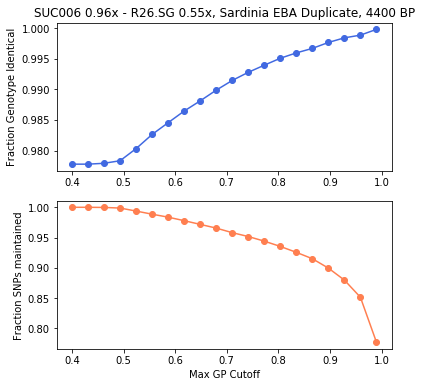

In [45]:
fig = plt.figure(figsize=(6,6))

gs = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[1,0])
ax = fig.add_subplot(gs[0, 0])
ax.plot(cutoffs, identical, "o-", c="royalblue")

ax.set_ylabel("Fraction Genotype Identical")
ax.set_title("SUC006 0.96x - R26.SG 0.55x, Sardinia EBA Duplicate, 4400 BP")

ax1.plot(cutoffs, snp_frac,"o-",c="coral")
ax1.set_xlabel("Max GP Cutoff")
ax1.set_ylabel("Fraction SNPs maintained")
#ax1.tick_params(axis='y', labelcolor="coral")
plt.show()

In [33]:
list(f["calldata/PL"][:10,100,:])

[array([ 0,  6, 62], dtype=int32),
 array([  0,  18, 178], dtype=int32),
 array([ 0,  3, 36], dtype=int32),
 array([ 0,  3, 36], dtype=int32),
 array([  0,  12, 124], dtype=int32),
 array([  0,  12, 123], dtype=int32),
 array([  0,  30, 249], dtype=int32),
 array([ 0,  6, 72], dtype=int32),
 array([ 0,  6, 72], dtype=int32),
 array([  0,  18, 180], dtype=int32)]

In [34]:
f["samples"][:]

array(['I0626_all', 'I0627_all', 'I1137_all_published', ...,
       'I5105_new.SG', 'I6729_new.SG', 'I6801_new.SG'], dtype=object)

In [35]:
j1 = get_idx_iid(f, "SUC006")